In [1]:
import pandas as pd,numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# read the data from .csv file
leads = pd.read_csv('Leads.csv')

In [3]:
leads.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [4]:
leads.shape

(9240, 37)

In [5]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

In [6]:
# prospect id and lead number column can be dropped as they are not useful
leads.drop(['Prospect ID','Lead Number'],axis=1,inplace = True)

In [7]:
# checking null values
leads.isnull().mean() * 100

Lead Origin                                       0.000000
Lead Source                                       0.389610
Do Not Email                                      0.000000
Do Not Call                                       0.000000
Converted                                         0.000000
TotalVisits                                       1.482684
Total Time Spent on Website                       0.000000
Page Views Per Visit                              1.482684
Last Activity                                     1.114719
Country                                          26.634199
Specialization                                   15.562771
How did you hear about X Education               23.885281
What is your current occupation                  29.112554
What matters most to you in choosing a course    29.318182
Search                                            0.000000
Magazine                                          0.000000
Newspaper Article                                 0.0000

## Handling Null values

### Dropping columns with more than 35% missing values

In [8]:
leads = leads.loc[:,(leads.isnull().mean() * 100) < 35][:]

In [9]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 29 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        6779 

In [10]:
leads.loc[:,leads.isnull().mean() * 100 > 15].head()

,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Lead Profile,City
0,NaN,Select,Select,Unemployed,Better Career Prospects,Select,Select
1,India,Select,Select,Unemployed,Better Career Prospects,Select,Select
2,India,Business Administration,Select,Student,Better Career Prospects,Potential Lead,Mumbai
3,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,Select,Mumbai
4,India,Select,Other,Unemployed,Better Career Prospects,Select,Mumbai


### Checking percentage of Select values in categorical columns, it is as good as having a null value

In [11]:
leads['Specialization'].value_counts(normalize = True) * 100

Select                               24.891054
Finance Management                   12.509613
Human Resource Management            10.869008
Marketing Management                 10.740836
Operations Management                 6.447065
Business Administration               5.165342
IT Projects Management                4.691105
Supply Chain Management               4.473212
Banking, Investment And Insurance     4.332223
Travel and Tourism                    2.601897
Media and Advertising                 2.601897
International Business                2.281466
Healthcare Management                 2.037939
Hospitality Management                1.461164
E-COMMERCE                            1.435529
Retail Management                     1.281723
Rural and Agribusiness                0.935658
E-Business                            0.730582
Services Excellence                   0.512689
Name: Specialization, dtype: float64

In [12]:
len(leads[(leads.Specialization == 'Select') | (leads.Specialization.isna())].Specialization)/len(leads) * 100

36.58008658008658

In [13]:
leads['How did you hear about X Education'].value_counts(normalize = True) * 100

Select                   71.704820
Online Search            11.488696
Word Of Mouth             4.948102
Student of SomeSchool     4.407792
Other                     2.644675
Multiple Sources          2.161240
Advertisements            0.995308
Social Media              0.952652
Email                     0.369686
SMS                       0.327030
Name: How did you hear about X Education, dtype: float64

In [14]:
# checking percentage of null values and select in the column
len(leads[(leads['How did you hear about X Education'] == 'Select') | (leads.Specialization.isna())]['How did you hear about X Education'])/len(leads) * 100

70.14069264069263

In [15]:
leads['What is your current occupation'].value_counts(normalize = True) * 100

Unemployed              85.496183
Working Professional    10.778626
Student                  3.206107
Other                    0.244275
Housewife                0.152672
Businessman              0.122137
Name: What is your current occupation, dtype: float64

In [16]:
leads['What matters most to you in choosing a course'].value_counts(normalize = True) * 100

Better Career Prospects      99.954065
Flexibility & Convenience     0.030623
Other                         0.015312
Name: What matters most to you in choosing a course, dtype: float64

In [17]:
leads['Lead Profile'].value_counts(normalize = True) * 100

Select                         63.481856
Potential Lead                 24.697596
Other Leads                     7.456745
Student of SomeSchool           3.690093
Lateral Student                 0.367478
Dual Specialization Student     0.306232
Name: Lead Profile, dtype: float64

In [18]:
# checking percentage of null values and select in the column
len(leads[(leads['Lead Profile'] == 'Select') | (leads.Specialization.isna())]['Lead Profile'])/len(leads) * 100

60.43290043290044

In [19]:
leads['City'].value_counts(normalize = True) * 100

Mumbai                         41.202046
Select                         28.759591
Thane & Outskirts               9.616368
Other Cities                    8.772379
Other Cities of Maharashtra     5.843990
Other Metro Cities              4.859335
Tier II Cities                  0.946292
Name: City, dtype: float64

In [20]:
# checking percentage of null values and select in the column
len(leads[(leads.City == 'Select') | (leads.Specialization.isna())].City)/len(leads) * 100

39.9025974025974

In [21]:
leads['Country'].value_counts(normalize = True) * 100

India                   95.766337
United States            1.017849
United Arab Emirates     0.781826
Singapore                0.354035
Saudi Arabia             0.309780
United Kingdom           0.221272
Australia                0.191769
Qatar                    0.147514
Hong Kong                0.103260
Bahrain                  0.103260
Oman                     0.088509
France                   0.088509
unknown                  0.073757
South Africa             0.059006
Nigeria                  0.059006
Germany                  0.059006
Kuwait                   0.059006
Canada                   0.059006
Sweden                   0.044254
China                    0.029503
Asia/Pacific Region      0.029503
Uganda                   0.029503
Bangladesh               0.029503
Italy                    0.029503
Belgium                  0.029503
Netherlands              0.029503
Ghana                    0.029503
Philippines              0.029503
Russia                   0.014751
Switzerland   

### Columns which has high percentage of null and select values combined can be dropped

### Column country has 26% missing data and 95% of leads are from India, so this column can be dropped

### Column "What matters most to you in choosing a course" 29% missing data and 99% data is "Better Career Prospects" this can also be dropped

In [22]:
# dropping columns
leads = leads.drop(['City','Lead Profile','How did you hear about X Education','Specialization','Country',
                    'What matters most to you in choosing a course'],axis = 1)

In [23]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Lead Origin                               9240 non-null   object 
 1   Lead Source                               9204 non-null   object 
 2   Do Not Email                              9240 non-null   object 
 3   Do Not Call                               9240 non-null   object 
 4   Converted                                 9240 non-null   int64  
 5   TotalVisits                               9103 non-null   float64
 6   Total Time Spent on Website               9240 non-null   int64  
 7   Page Views Per Visit                      9103 non-null   float64
 8   Last Activity                             9137 non-null   object 
 9   What is your current occupation           6550 non-null   object 
 10  Search                              

In [24]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,...,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Unemployed,...,No,No,No,No,No,No,No,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Student,...,No,No,No,No,No,No,No,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified


In [25]:
leads['Lead Source'].value_counts(normalize = True) * 100

Google               31.160365
Direct Traffic       27.629292
Olark Chat           19.067797
Organic Search       12.538027
Reference             5.801825
Welingak Website      1.542807
Referral Sites        1.358105
Facebook              0.597566
bing                  0.065189
google                0.054324
Click2call            0.043459
Press_Release         0.021730
Social Media          0.021730
Live Chat             0.021730
youtubechannel        0.010865
testone               0.010865
Pay per Click Ads     0.010865
welearnblog_Home      0.010865
WeLearn               0.010865
blog                  0.010865
NC_EDM                0.010865
Name: Lead Source, dtype: float64

In [26]:
# Google is spelled as google, lets correct
leads['Lead Source'] = leads['Lead Source'].map(lambda x: 'Google' if x == 'google' else x)

In [27]:
leads['Lead Source'].value_counts(normalize = True) * 100

Google               31.214689
Direct Traffic       27.629292
Olark Chat           19.067797
Organic Search       12.538027
Reference             5.801825
Welingak Website      1.542807
Referral Sites        1.358105
Facebook              0.597566
bing                  0.065189
Click2call            0.043459
Social Media          0.021730
Live Chat             0.021730
Press_Release         0.021730
Pay per Click Ads     0.010865
blog                  0.010865
WeLearn               0.010865
welearnblog_Home      0.010865
youtubechannel        0.010865
testone               0.010865
NC_EDM                0.010865
Name: Lead Source, dtype: float64

### Fill categorical columns null value with most commonly occuring value

In [28]:
leads['Lead Source'] = leads['Lead Source'].fillna(leads['Lead Source'].mode()[0])

In [29]:
leads['Last Activity'].fillna(leads['Last Activity'].mode()[0],inplace = True)

In [30]:
leads['What is your current occupation'].fillna(leads['What is your current occupation'].mode()[0],inplace = True)

### Handling null values in numerical column

In [31]:
np.nanpercentile(leads.TotalVisits,[98,99])

array([13., 17.])

In [32]:
np.nanpercentile(leads['Page Views Per Visit'],[98,99])

array([8., 9.])

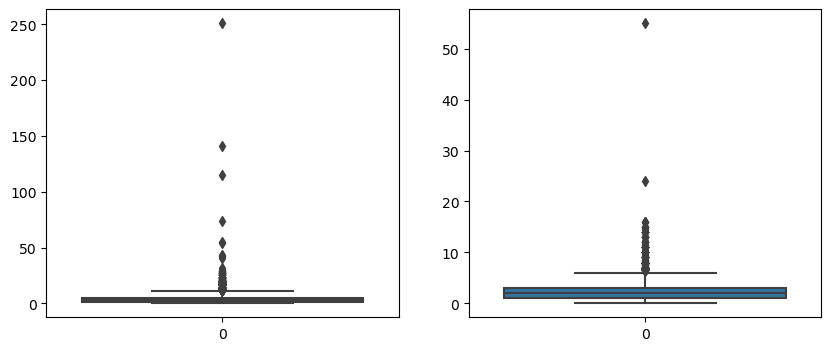

In [33]:
# analyzing numerical columns
plt.figure(figsize=[10,4])

plt.subplot(1,2,1)
sns.boxplot(leads.TotalVisits)

plt.subplot(1,2,2)
sns.boxplot(leads['Page Views Per Visit'])
plt.show()

In [34]:
leads.TotalVisits.fillna(np.nanmedian(leads['TotalVisits']),inplace = True)

### Fill numerical columns null value with median

In [35]:
leads['Page Views Per Visit'].fillna(np.nanmedian(leads['Page Views Per Visit']),inplace = True)

In [36]:
# checking null values
leads.isna().mean() * 100

Lead Origin                                 0.0
Lead Source                                 0.0
Do Not Email                                0.0
Do Not Call                                 0.0
Converted                                   0.0
TotalVisits                                 0.0
Total Time Spent on Website                 0.0
Page Views Per Visit                        0.0
Last Activity                               0.0
What is your current occupation             0.0
Search                                      0.0
Magazine                                    0.0
Newspaper Article                           0.0
X Education Forums                          0.0
Newspaper                                   0.0
Digital Advertisement                       0.0
Through Recommendations                     0.0
Receive More Updates About Our Courses      0.0
Update me on Supply Chain Content           0.0
Get updates on DM Content                   0.0
I agree to pay the amount through cheque

### There are no null values in any column

In [37]:
#leads['Lead Source'].value_counts(normalize = True) * 100

In [38]:
leads.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,What is your current occupation,...,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified
1,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,Unemployed,...,No,No,No,No,No,No,No,No,No,Email Opened
2,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,Student,...,No,No,No,No,No,No,No,No,Yes,Email Opened
3,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified
4,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,Unemployed,...,No,No,No,No,No,No,No,No,No,Modified


In [39]:
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 23 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Lead Origin                               9240 non-null   object 
 1   Lead Source                               9240 non-null   object 
 2   Do Not Email                              9240 non-null   object 
 3   Do Not Call                               9240 non-null   object 
 4   Converted                                 9240 non-null   int64  
 5   TotalVisits                               9240 non-null   float64
 6   Total Time Spent on Website               9240 non-null   int64  
 7   Page Views Per Visit                      9240 non-null   float64
 8   Last Activity                             9240 non-null   object 
 9   What is your current occupation           9240 non-null   object 
 10  Search                              

In [40]:
leads.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Last Activity',
       'What is your current occupation', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

In [41]:
# making a list of columns which has yes or no values
binary_columns = ['Do Not Email','Do Not Call','Search','Magazine','Newspaper Article','X Education Forums',
                 'Newspaper','Digital Advertisement', 'Through Recommendations','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content', 'Get updates on DM Content','I agree to pay the amount through cheque',
                  'A free copy of Mastering The Interview']

In [42]:
# making a list of columns for which dummy variable needs to be created
dummy_var_cols = ['Lead Origin','Lead Source','Last Activity','What is your current occupation',
                  'Last Notable Activity']

In [43]:
# making a list of numerical columns
num_cols = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']

In [44]:
# converting yes or no values in columns to 1 and 0
leads[binary_columns] = leads[binary_columns].apply(lambda x: x.map({'Yes':1,'No':0}))

In [45]:
leads[binary_columns].head()

,Do Not Email,Do Not Call,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,I agree to pay the amount through cheque,A free copy of Mastering The Interview
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0


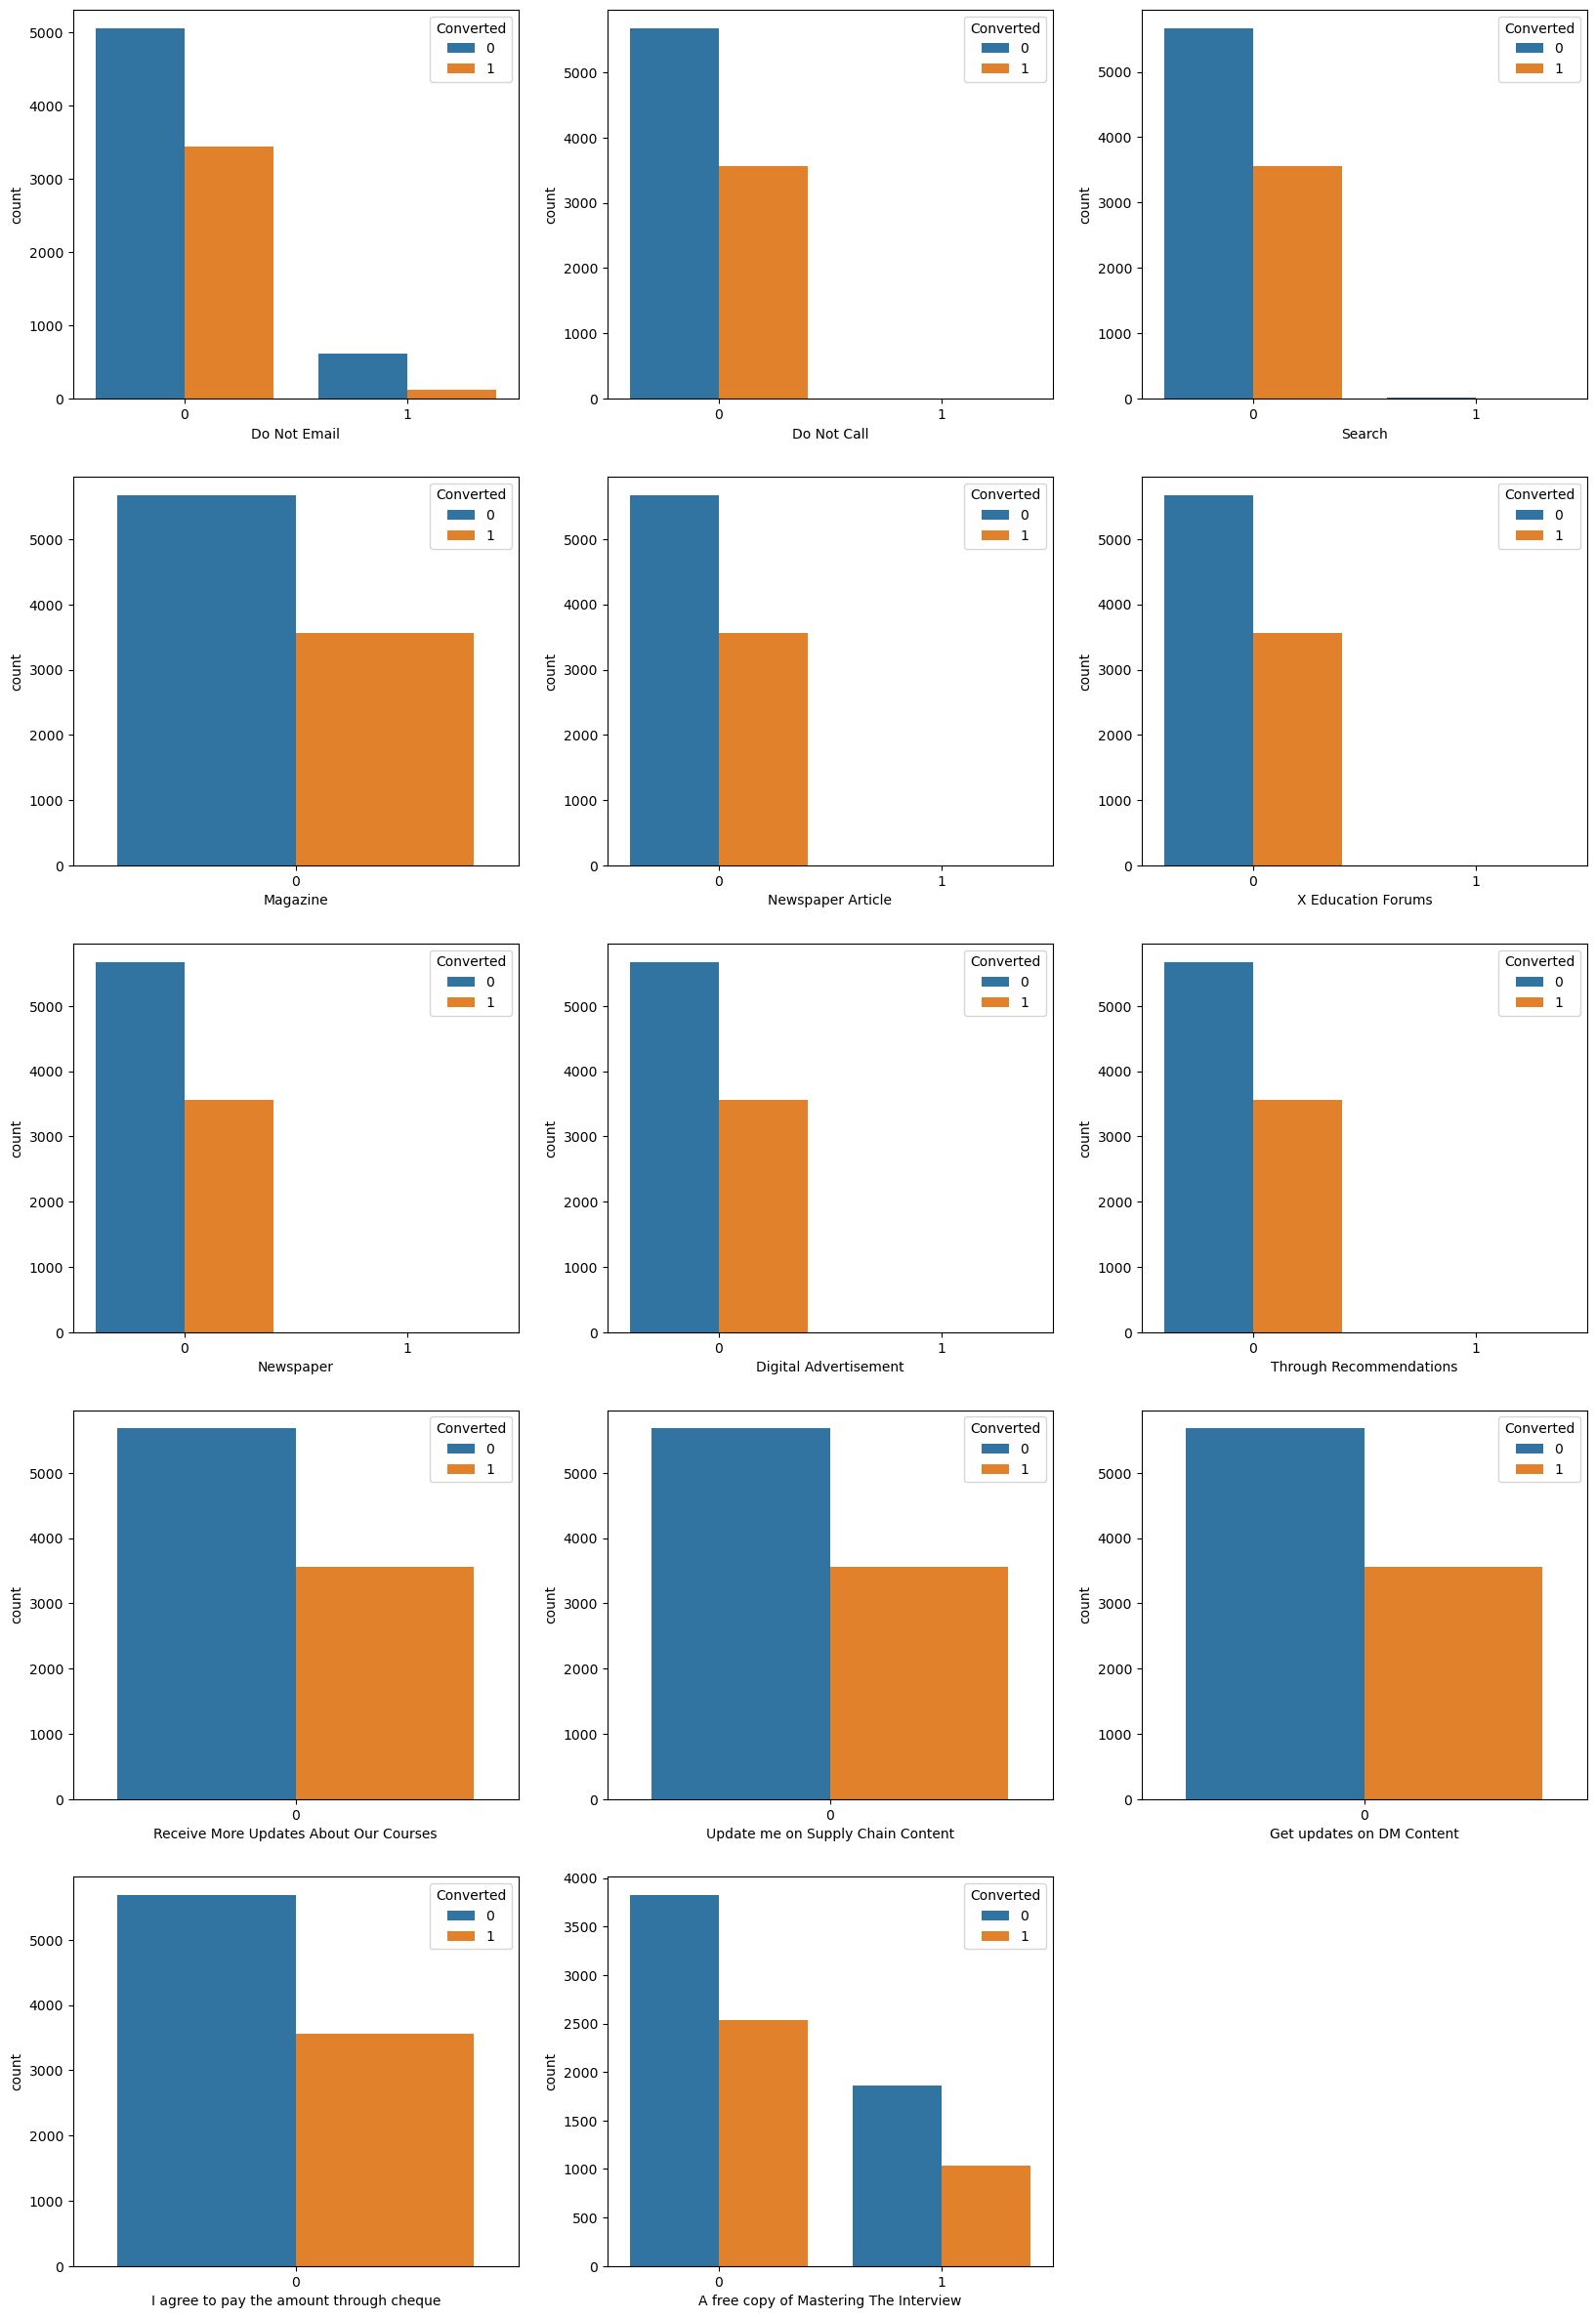

In [46]:
plt.figure(figsize = (20,30))
for i in range(0,14):
    plt.subplot(5,3,i+1)
    sns.countplot(leads,x = binary_columns[i],hue = 'Converted')

plt.show()

### There seems to be no visible pattern for the above columns

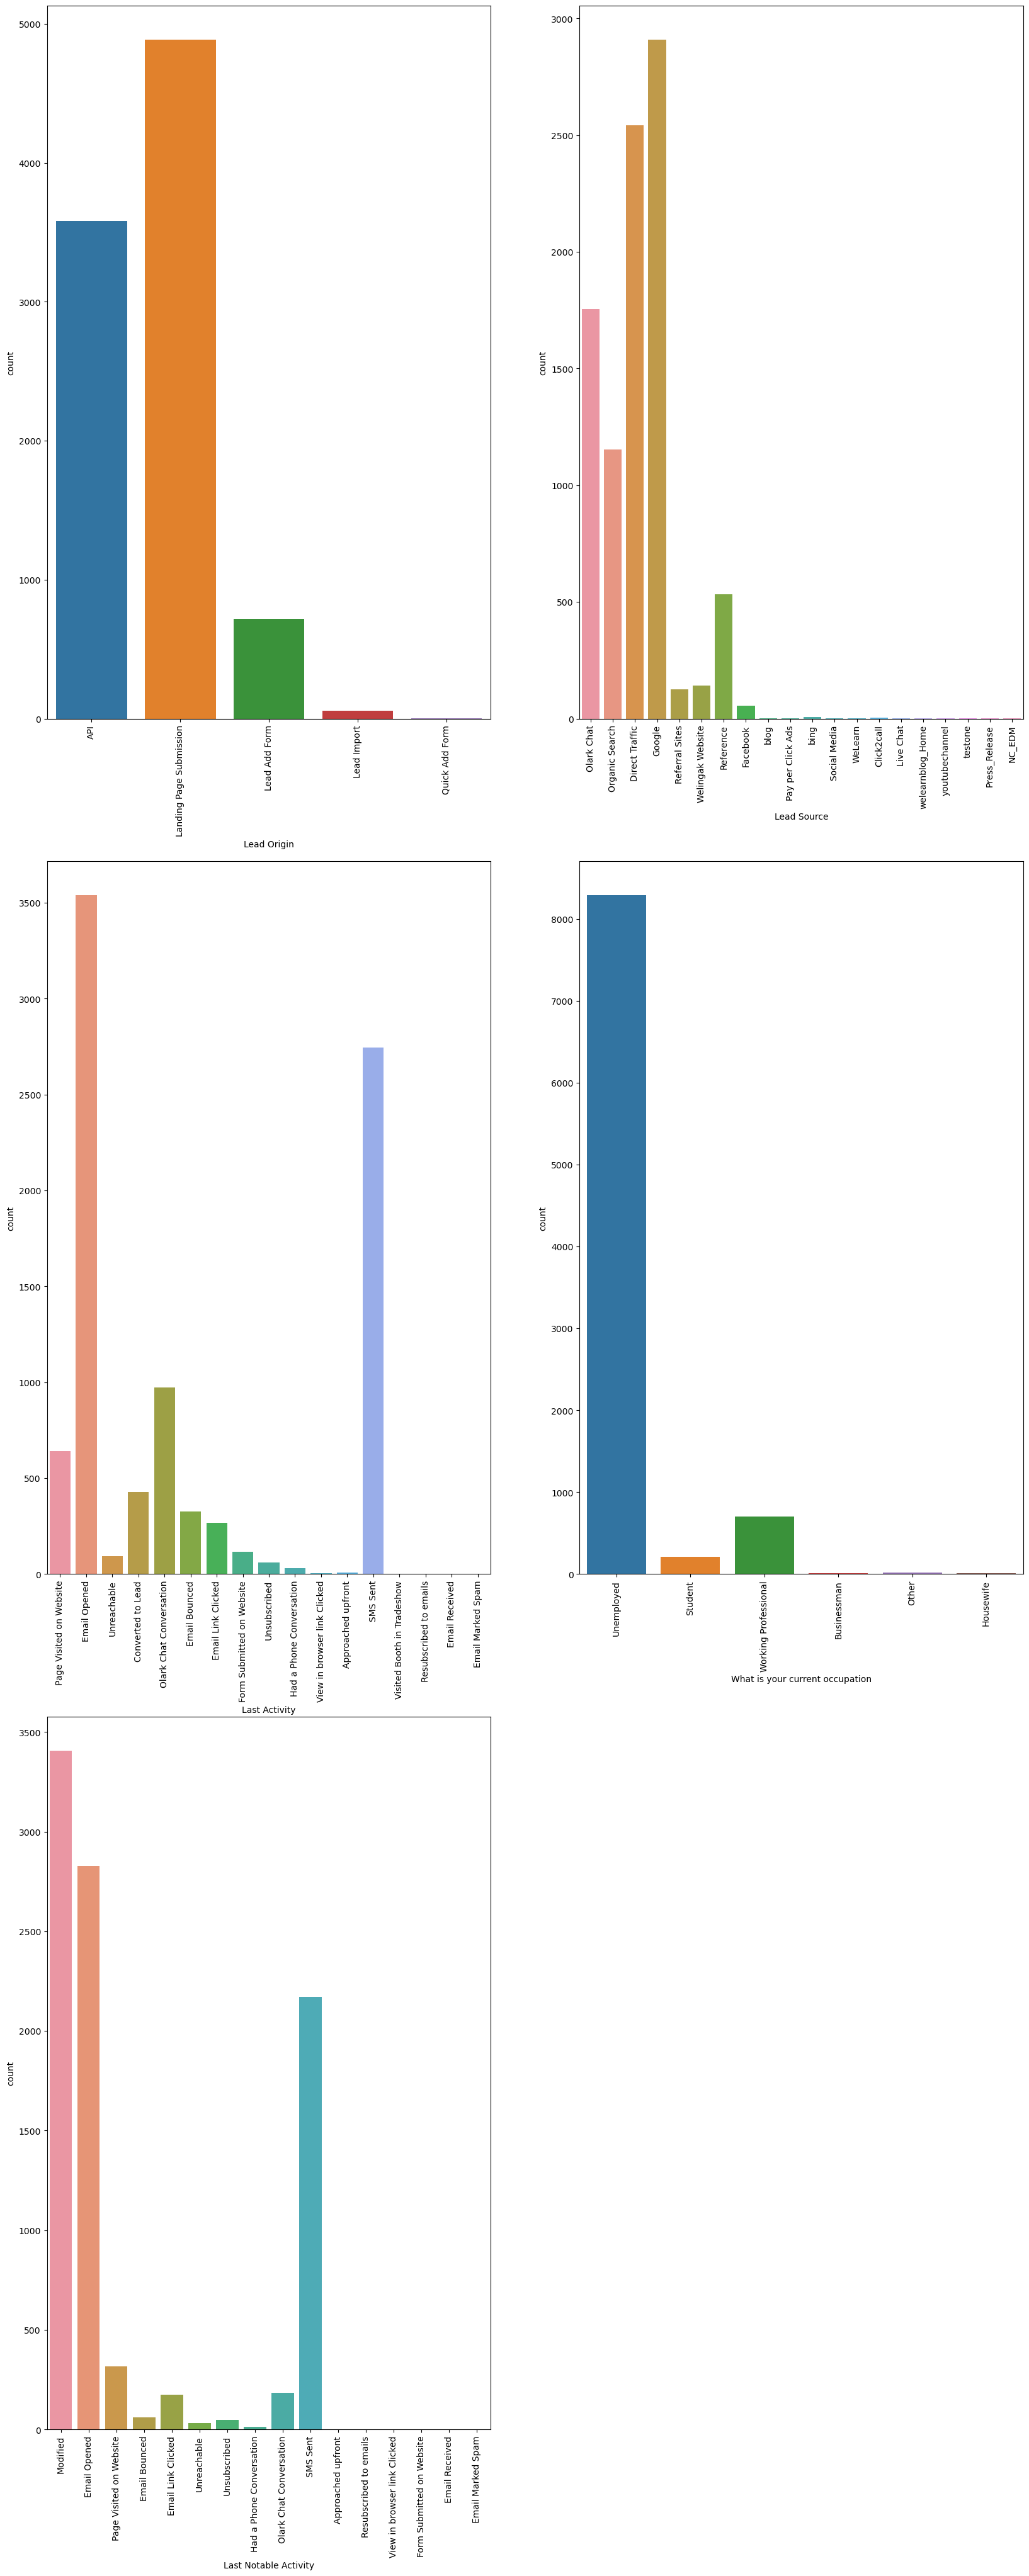

In [47]:
plt.figure(figsize = (20,50))
for i in range(0,5):
    plt.subplot(3,2,i+1)
    sns.countplot(leads,x = dummy_var_cols[i])
    plt.xticks(rotation = 90)

plt.show()

In [48]:
#sns.countplot(leads,x = leads['Last Activity'])
#sns.countplot(leads,x = leads['Last Activity'])
#plt.xticks(rotation = 90)

#plt.show()

In [49]:
#sns.countplot(leads,x = leads['Last Activity'],hue = 'Converted')
#sns.countplot(leads,x = leads['Last Activity'],hue = 'Converted')
#plt.xticks(rotation = 90)

#plt.show()

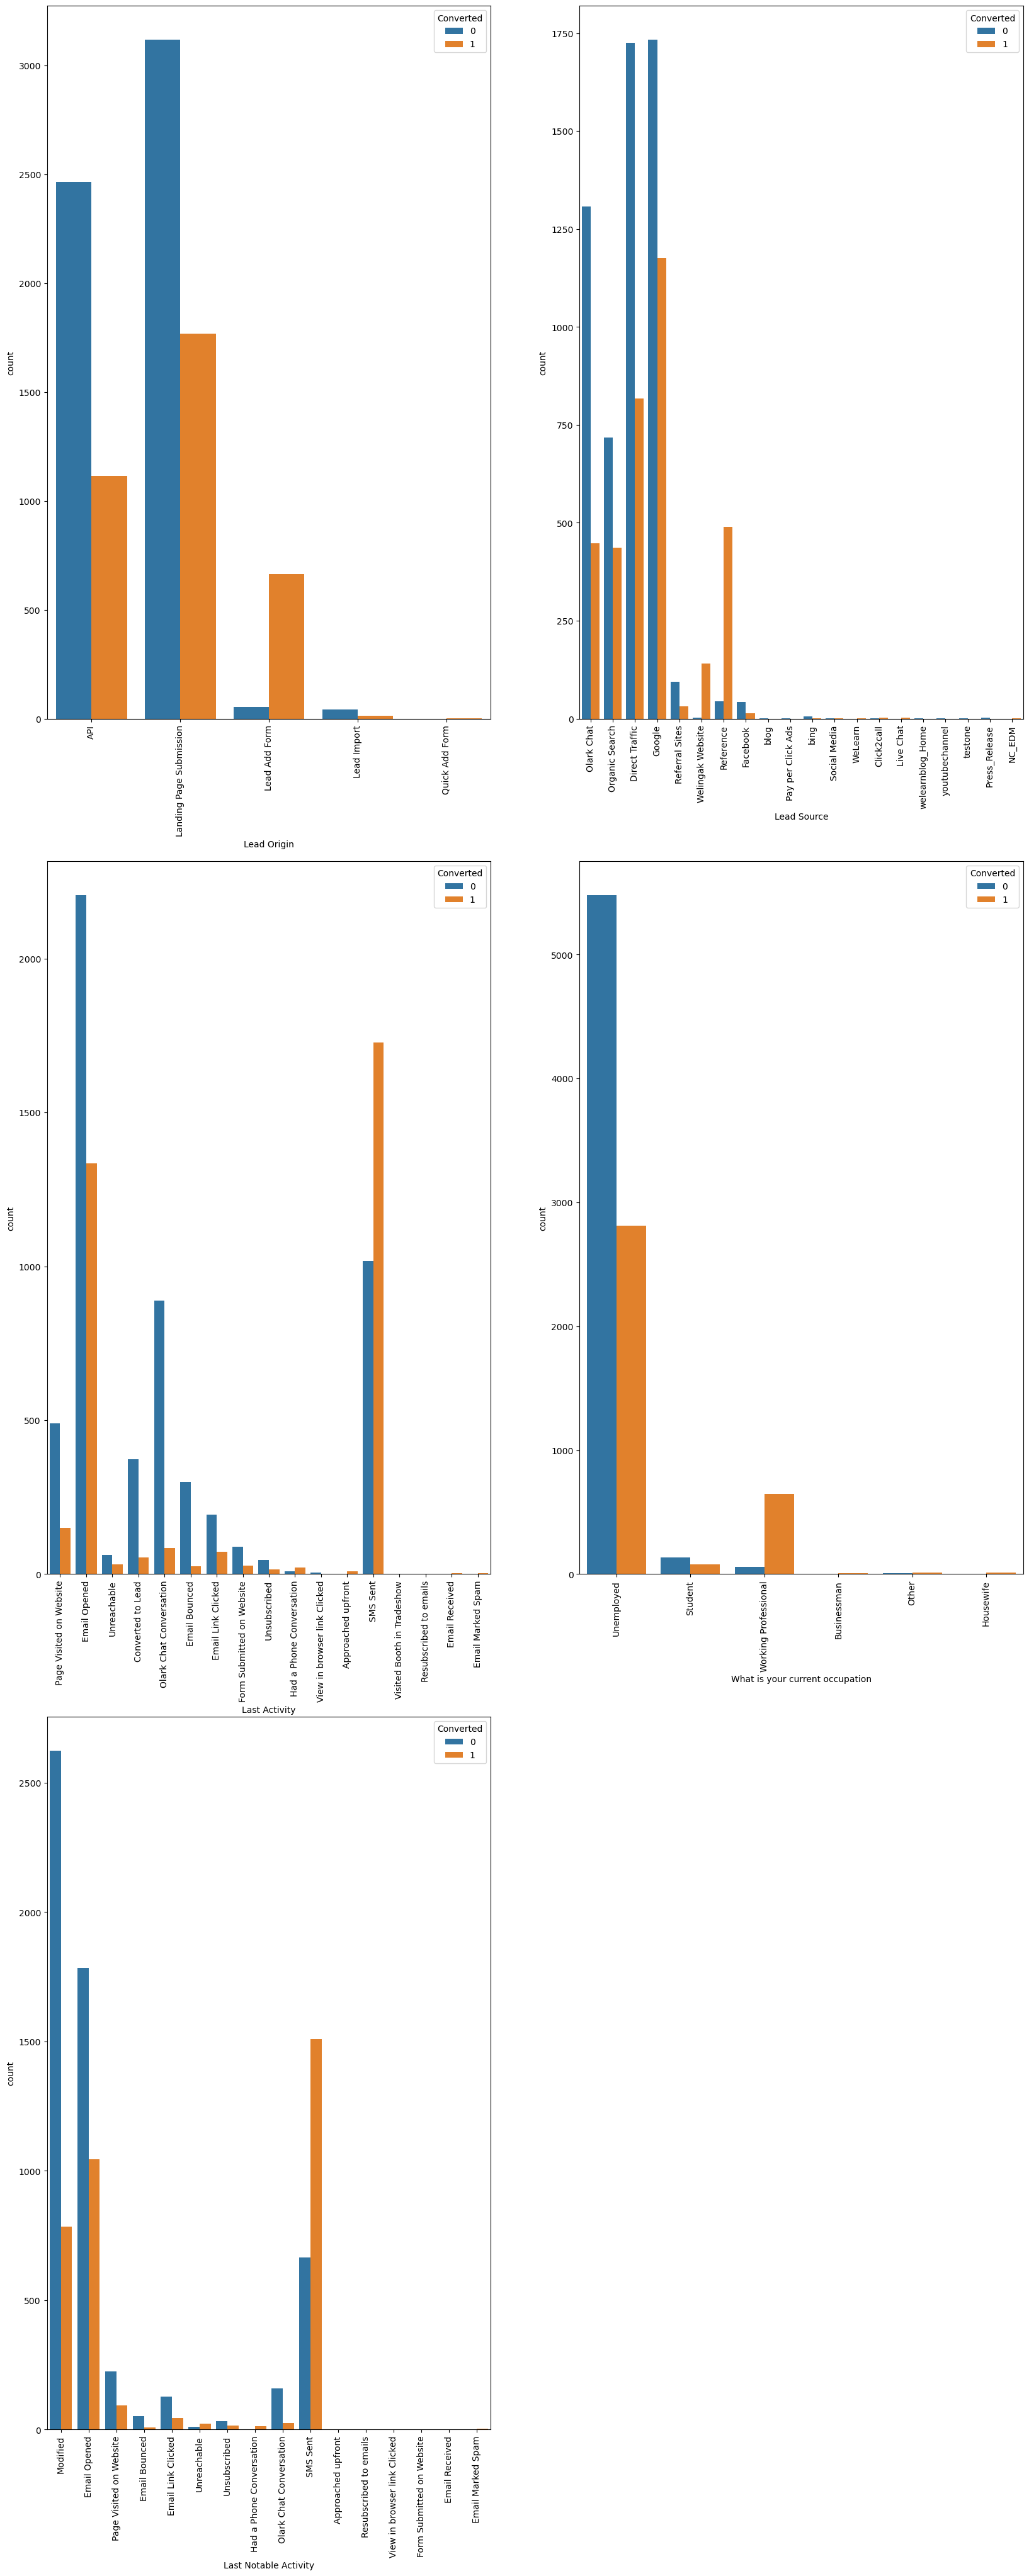

In [50]:
plt.figure(figsize = (20,50))
for i in range(0,5):
    plt.subplot(3,2,i+1)
    sns.countplot(leads,x = dummy_var_cols[i],hue = 'Converted')
    plt.xticks(rotation = 90)

plt.show()

### Lead Origin : most number of leads are from identified through 'Landing Page Submission'
### Lead Source : most of the lead source is from 'Google'
### Last activity : most of the leads last activitu is 'Email Opened' and 'SMS sent'
### Most of the leads are unemployed individuals

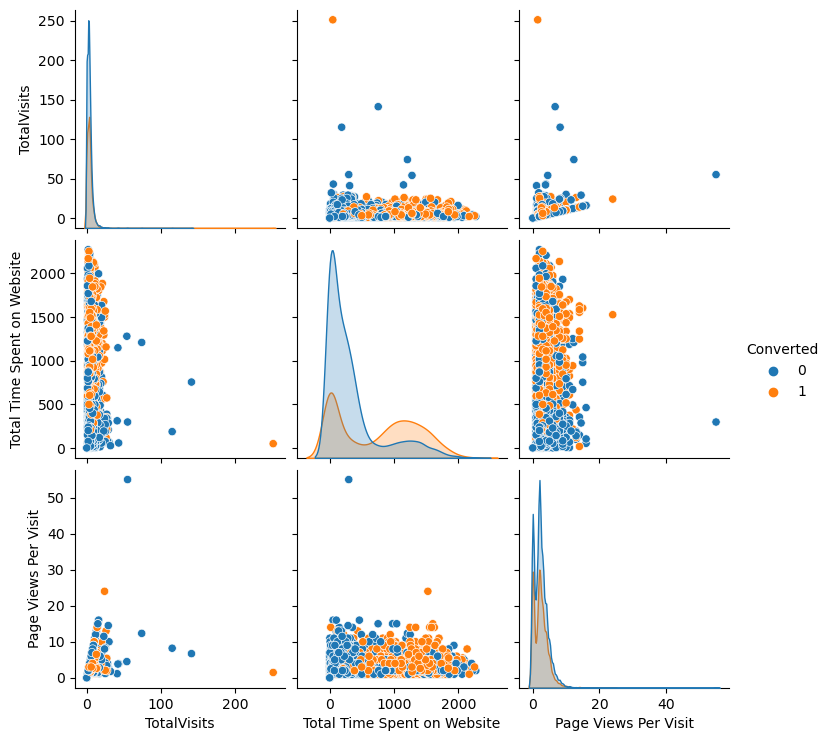

In [51]:
sns.pairplot(leads[num_cols + ['Converted']],hue = 'Converted')
plt.show()

### 'Page Views Per Visit' and 'TotalVisits' column has linear relation between them

In [52]:
# creating dummy variables for categorical variables
dummy = pd.get_dummies(leads[dummy_var_cols],drop_first = True)
dummy.head()

,Lead Origin_Landing Page Submission,Lead Origin_Lead Add Form,Lead Origin_Lead Import,Lead Origin_Quick Add Form,Lead Source_Direct Traffic,Lead Source_Facebook,Lead Source_Google,Lead Source_Live Chat,Lead Source_NC_EDM,Lead Source_Olark Chat,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [53]:
# concatenating the two dataframes
leads = pd.concat([leads,dummy],axis = 1)

In [54]:
# dropping columns for which dummy variables are created
leads.drop(dummy_var_cols,axis = 1,inplace = True)
leads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 77 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Do Not Email                                          9240 non-null   int64  
 1   Do Not Call                                           9240 non-null   int64  
 2   Converted                                             9240 non-null   int64  
 3   TotalVisits                                           9240 non-null   float64
 4   Total Time Spent on Website                           9240 non-null   int64  
 5   Page Views Per Visit                                  9240 non-null   float64
 6   Search                                                9240 non-null   int64  
 7   Magazine                                              9240 non-null   int64  
 8   Newspaper Article                                     9240

In [55]:
# checking percentiles
leads[num_cols].describe(percentiles = [.25,.5,.75,.90,.95,.99])

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9240.000000,9240.000000
mean,3.438636,487.698268,2.357440
std,4.819024,548.021466,2.145781
min,0.000000,0.000000,0.000000
25%,1.000000,12.000000,1.000000
50%,3.000000,248.000000,2.000000
75%,5.000000,936.000000,3.000000
90%,7.000000,1380.000000,5.000000
95%,10.000000,1562.000000,6.000000
99%,17.000000,1840.610000,9.000000


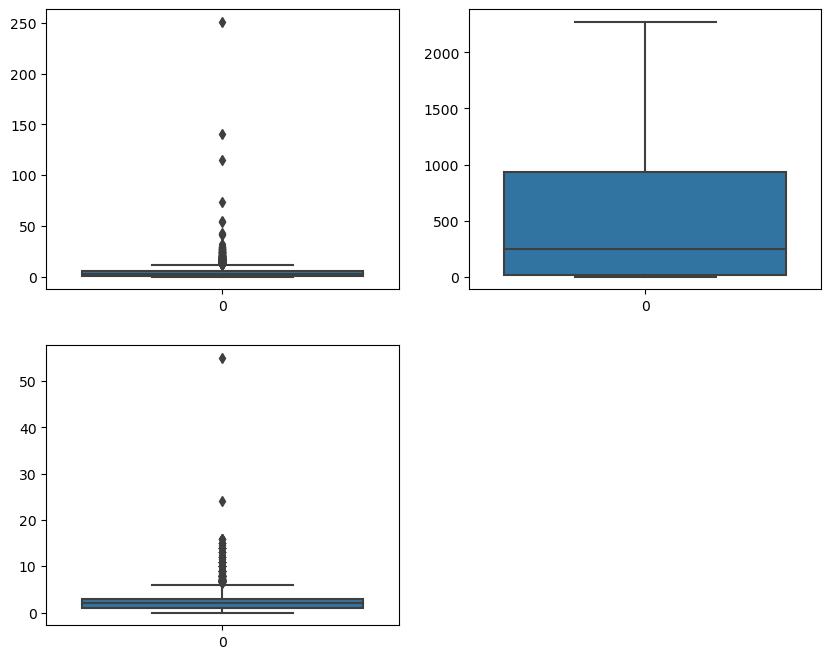

In [56]:
# analyzing numerical columns
plt.figure(figsize = [10,8])
plt.subplot(2,2,1)
sns.boxplot(leads['TotalVisits'])

plt.subplot(2,2,2)
sns.boxplot(leads['Total Time Spent on Website'])

plt.subplot(2,2,3)
sns.boxplot(leads['Page Views Per Visit'])

plt.show()

### There are outliers in "TotalVisits" and Total "Time Spent on Website" columns
### we can use minmaxscaler for scaling the data which will also take care of outliers

## Train - Test split

In [57]:
# creating a dataframe of all the independent variables
X = leads.drop(['Converted'],axis = 1)
X.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
0,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,0,0,5.0,674,2.5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,2.0,1532,2.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1.0,305,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,2.0,1428,1.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [58]:
# creating a dataframe of target variable
y = leads['Converted']
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [59]:
# Splitting data into train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7,test_size=0.3,random_state = 100)

## Feature scaling

In [60]:
# scaling numerical columns
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_train.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
1871,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6795,0,0,0.015936,0.214349,0.024182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3516,0,0,0.019920,0.046655,0.045455,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8105,0,0,0.019920,0.541373,0.090909,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3934,0,0,0.000000,0.000000,0.000000,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [61]:
X_train[num_cols].describe()

,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,6468.000000,6468.000000,6468.000000
mean,0.013815,0.212974,0.042686
std,0.021048,0.240566,0.039326
min,0.000000,0.000000,0.000000
25%,0.003984,0.005282,0.018182
50%,0.011952,0.108275,0.036364
75%,0.019920,0.407790,0.054545
max,1.000000,1.000000,1.000000


### values of numerical columns is between 0 to 1 after scaling

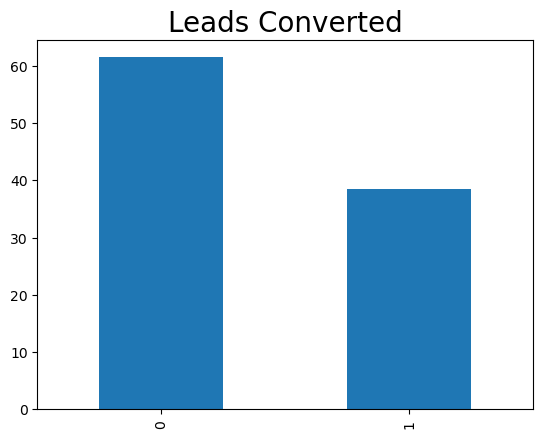

In [62]:
vals = leads['Converted'].value_counts(normalize = True) * 100
vals.plot(kind = 'bar')
plt.title(label="Leads Converted",fontsize=20,color="black")
plt.show()

In [63]:
# checking data imbalance for target variable
sum(leads['Converted'])/len(leads['Converted']) * 100

38.53896103896104

### Around 39% of leads have enrolled to the program, so no need to worry much about class imbalance

In [64]:
X_test.head()

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
4269,0,0,8.0,1011,8.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2376,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7766,0,0,5.0,59,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
9199,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4359,0,0,0.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Model Building

### Model 1

In [65]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)),family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6401
Model Family:                Binomial   Df Model:                           66
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 21 Nov 2023   Deviance:                   1.9950e+05
Time:                        18:05:49   Pearson chi2:                 9.75e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                 -2.07e+15   5.25e+07  -3.94e+07      0.000   -2.07e+15   -2.07e+15
Do Not Email                                         -4.525e+13   4.43e+06  -1.02e+07      0.000   -4.53e+13   -4.53e+13
Do Not Call                                           8.266e+15   4.75e+07   1.74e+08      0.000    8.27e+15    8.27e+15
TotalVisits                                           3.701e+15   4.72e+07   7.84e+07      0.000     3.7e+15     3.7e+15
Total Time Spent on Website                           3.116e+15   3.94e+06   7.91e+08      0.000    3.12e+15    3.12e+15
Page Views Per Visit                                 -2.949e+15   3.03e+07  -9.72e+07      0.000   -2.95e+15   -2.95e+15
Search                                               -1.352e+14    2.2e+07  -6.13e+06      0.000   -1.35e+14   -1.35e+14
Magazine                                                 4.2627   1.48e-07   2.88e+07      0.000       4.263       4.263
Newspaper Article                                     1.938e+15   6.73e+07   2.88e+07      0.000    1.94e+15    1.94e+15
X Education Forums                                    4.556e+12   1.11e+08    4.1e+04      0.000    4.56e+12    4.56e+12
Newspaper                                            -7.267e+15   6.72e+07  -1.08e+08      0.000   -7.27e+15   -7.27e+15
Digital Advertisement                                -3.582e+15   4.76e+07  -7.53e+07      0.000   -3.58e+15   -3.58e+15
Through Recommendations                              -4.559e+14   2.85e+07   -1.6e+07      0.000   -4.56e+14   -4.56e+14
Receive More Updates About Our Courses                   6.8332   1.35e-07   5.07e+07      0.000       6.833       6.833
Update me on Supply Chain Content                       -2.4507    1.5e-07  -1.63e+07      0.000      -2.451      -2.451
Get updates on DM Content                              -16.3599   1.43e-07  -1.14e+08      0.000     -16.360     -16.360
I agree to pay the amount through cheque                -1.6479   1.34e-07  -1.23e+07      0.000      -1.648      -1.648
A free copy of Mastering The Interview               -7.624e+13   2.59e+06  -2.94e+07      0.000   -7.62e+13   -7.62e+13
Lead Origin_Landing Page Submission                  -4.214e+13   2.65e+06  -1.59e+07      0.000   -4.21e+13   -4.21e+13
Lead Origin_Lead Add Form                                 2e+15    1.3e+07   1.54e+08      0.000       2e+15       2e+15
Lead Origin_Lead Import                              -2.248e+15    4.8e+07  -4.68e+07      0.000   -2.25e+15   -2.25e+15
Lead Origin_Quick Add Form                            2.458e+15   6.74e+07   3.65e+07      0.000    2.46e+15    2.46e+15
Lead Source_Direct Traffic                            2.14

### Checking VIF

In [66]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
50,Last Activity_Resubscribed to emails,inf
71,Last Notable Activity_Resubscribed to emails,inf
63,Last Notable Activity_Email Marked Spam,inf
43,Last Activity_Email Marked Spam,inf
68,Last Notable Activity_Modified,1691.89
...,...,...
13,Update me on Supply Chain Content,NaN
14,Get updates on DM Content,NaN
15,I agree to pay the amount through cheque,NaN
37,Lead Source_testone,NaN


### Some features are highly correlated so the first model built is not very efficient
### First model also has P-values as zero for all features which is not as expected which might be due to very high correlation

In [67]:
# creating a logistic regression instance
logreg = LogisticRegression()

In [68]:
# select 20 features
rfe = RFE(logreg,n_features_to_select = 20)
rfe = rfe.fit(X_train,y_train)

In [69]:
# True : columns selected False: columns not selected by RFE
rfe.support_

array([ True, False,  True,  True,  True, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True, False,
       False, False, False, False])

In [70]:
# checking columns selection status and their rank
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 4),
 ('TotalVisits', True, 1),
 ('Total Time Spent on Website', True, 1),
 ('Page Views Per Visit', True, 1),
 ('Search', False, 20),
 ('Magazine', False, 54),
 ('Newspaper Article', False, 16),
 ('X Education Forums', False, 37),
 ('Newspaper', False, 3),
 ('Digital Advertisement', True, 1),
 ('Through Recommendations', False, 27),
 ('Receive More Updates About Our Courses', False, 52),
 ('Update me on Supply Chain Content', False, 51),
 ('Get updates on DM Content', False, 55),
 ('I agree to pay the amount through cheque', False, 53),
 ('A free copy of Mastering The Interview', False, 49),
 ('Lead Origin_Landing Page Submission', False, 38),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', False, 45),
 ('Lead Origin_Quick Add Form', False, 12),
 ('Lead Source_Direct Traffic', False, 19),
 ('Lead Source_Facebook', False, 23),
 ('Lead Source_Google', False, 26),
 ('Lead Source_Live Chat', False, 41),
 ('Lead Sourc

In [71]:
# creating a list of 20 columns selected by RFE
col = X_train.columns[rfe.support_]

In [72]:
# columns which are not selected by RFE
X_train.columns[~rfe.support_]

Index(['Do Not Call', 'Search', 'Magazine', 'Newspaper Article',
       'X Education Forums', 'Newspaper', 'Through Recommendations',
       'Receive More Updates About Our Courses',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Lead Import',
       'Lead Origin_Quick Add Form', 'Lead Source_Direct Traffic',
       'Lead Source_Facebook', 'Lead Source_Google', 'Lead Source_Live Chat',
       'Lead Source_NC_EDM', 'Lead Source_Organic Search',
       'Lead Source_Pay per Click Ads', 'Lead Source_Press_Release',
       'Lead Source_Reference', 'Lead Source_Referral Sites',
       'Lead Source_Social Media', 'Lead Source_WeLearn', 'Lead Source_bing',
       'Lead Source_blog', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Last Activity_Email Link Clicke

### Assessing the model with Statsmodels

### Model 2

In [73]:
# adding constant to independent variables since we are using statsmodels for detailed analysis of the model
X_train_sm = sm.add_constant(X_train[col])

# building a logistic regression model
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())

res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6447
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2673.3
Date:                Tue, 21 Nov 2023   Deviance:                       5346.7
Time:                        18:05:54   Pearson chi2:                 7.38e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.3951
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8165      0.105     -7.746      0.000      -1.023      -0.610
Do Not Email                                            -1.3314      0.196     -6.776      0.000      -1.717      -0.946
TotalVisits                                              9.1376      2.422      3.772      0.000       4.390      13.885
Total Time Spent on Website                              4.5587      0.165     27.698      0.000       4.236       4.881
Page Views Per Visit                                    -3.7173      1.295     -2.871      0.004      -6.255      -1.180
Digital Advertisement                                  -22.0774   2.77e+04     -0.001      0.999   -5.43e+04    5.43e+04
Lead Origin_Lead Add Form                                3.6742      0.200     18.365      0.000       3.282       4.066
Lead Source_Olark Chat                                   1.0830      0.120      9.031      0.000       0.848       1.318
Lead Source_Welingak Website                             1.9801      0.744      2.662      0.008       0.522       3.438
Last Activity_Converted to Lead                         -1.0514      0.229     -4.592      0.000      -1.500      -0.603
Last Activity_Email Bounced                             -1.1190      0.348     -3.217      0.001      -1.801      -0.437
Last Activity_Had a Phone Conversation                   0.6392      0.957      0.668      0.504      -1.237       2.516
Last Activity_Olark Chat Conversation                   -1.2323      0.193     -6.369      0.000      -1.612      -0.853
What is your current occupation_Housewife               22.9170   1.38e+04      0.002      0.999    -2.7e+04    2.71e+04
What is your current occupation_Working Professional     2.8054      0.189     14.879      0.000       2.436       3.175
Last Notable Activity_Email Link Clicked                -1.9145      0.272     -7.047      0.000      -2.447      -1.382
Last Notable Activity_Email Opened                      -1.3386      0.087    -15.385      0.000      -1.509      -1.168
Last Notable Activity_Had a Phone Conversation           1.3894      1.461      0.951      0.342      -1.474       4.252
Last Notable Activity_Modified                          -1.6917      0.100    -16.997      0.000      -1.887      -1.497
Last Notable Activity_Olark Chat Conversation           -1.4808      0.377     -3.930      0.000      -2.219      -0.742
Last Notable Activity_Page Visited on Website           -1.8496      0.204     -9.073      0.000      -2.249      -1.450
========================================================================================================================
"""

### There are quite few columns with P value > 0.05 (5%)
### These columns need to be dropped one by one and rebuild the model again

### Model 3

In [74]:
# dropping column Digital Advertisement
col = col.drop('What is your current occupation_Housewife')

X_train_sm = sm.add_constant(X_train[col])

logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())

res = logm3.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2680.5
Date:                Tue, 21 Nov 2023   Deviance:                       5361.0
Time:                        18:05:54   Pearson chi2:                 7.41e+03
No. Iterations:                    20   Pseudo R-squ. (CS):             0.3938
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8110      0.105     -7.700      0.000      -1.017      -0.605
Do Not Email                                            -1.3341      0.196     -6.790      0.000      -1.719      -0.949
TotalVisits                                              9.0631      2.415      3.753      0.000       4.330      13.797
Total Time Spent on Website                              4.5550      0.164     27.709      0.000       4.233       4.877
Page Views Per Visit                                    -3.7554      1.294     -2.903      0.004      -6.291      -1.220
Digital Advertisement                                  -21.0786   1.68e+04     -0.001      0.999   -3.29e+04    3.29e+04
Lead Origin_Lead Add Form                                3.6872      0.200     18.468      0.000       3.296       4.078
Lead Source_Olark Chat                                   1.0730      0.120      8.961      0.000       0.838       1.308
Lead Source_Welingak Website                             1.9561      0.744      2.630      0.009       0.498       3.414
Last Activity_Converted to Lead                         -1.0625      0.229     -4.644      0.000      -1.511      -0.614
Last Activity_Email Bounced                             -1.1243      0.348     -3.231      0.001      -1.806      -0.442
Last Activity_Had a Phone Conversation                   0.6281      0.958      0.656      0.512      -1.249       2.505
Last Activity_Olark Chat Conversation                   -1.2389      0.193     -6.407      0.000      -1.618      -0.860
What is your current occupation_Working Professional     2.7996      0.189     14.850      0.000       2.430       3.169
Last Notable Activity_Email Link Clicked                -1.8955      0.269     -7.043      0.000      -2.423      -1.368
Last Notable Activity_Email Opened                      -1.3323      0.087    -15.327      0.000      -1.503      -1.162
Last Notable Activity_Had a Phone Conversation           1.4001      1.461      0.958      0.338      -1.463       4.264
Last Notable Activity_Modified                          -1.6823      0.099    -16.932      0.000      -1.877      -1.488
Last Notable Activity_Olark Chat Conversation           -1.4706      0.377     -3.904      0.000      -2.209      -0.732
Last Notable Activity_Page Visited on Website           -1.8477      0.204     -9.068      0.000      -2.247      -1.448
========================================================================================================================
"""

### Model 4

In [75]:
# dropping column "What is your current occupation_Housewife"
col = col.drop('Digital Advertisement')

X_train_sm = sm.add_constant(X_train[col])

logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())

res = logm4.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6449
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2681.9
Date:                Tue, 21 Nov 2023   Deviance:                       5363.8
Time:                        18:05:54   Pearson chi2:                 7.41e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3935
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8116      0.105     -7.707      0.000      -1.018      -0.605
Do Not Email                                            -1.3303      0.196     -6.772      0.000      -1.715      -0.945
TotalVisits                                              8.9232      2.398      3.720      0.000       4.222      13.624
Total Time Spent on Website                              4.5587      0.164     27.732      0.000       4.237       4.881
Page Views Per Visit                                    -3.7800      1.291     -2.929      0.003      -6.309      -1.251
Lead Origin_Lead Add Form                                3.6863      0.200     18.465      0.000       3.295       4.078
Lead Source_Olark Chat                                   1.0720      0.120      8.954      0.000       0.837       1.307
Lead Source_Welingak Website                             1.9558      0.744      2.630      0.009       0.498       3.414
Last Activity_Converted to Lead                         -1.0619      0.229     -4.641      0.000      -1.510      -0.613
Last Activity_Email Bounced                             -1.1262      0.348     -3.237      0.001      -1.808      -0.444
Last Activity_Had a Phone Conversation                   0.6299      0.958      0.658      0.511      -1.248       2.507
Last Activity_Olark Chat Conversation                   -1.2373      0.193     -6.399      0.000      -1.616      -0.858
What is your current occupation_Working Professional     2.8009      0.189     14.857      0.000       2.431       3.170
Last Notable Activity_Email Link Clicked                -1.8927      0.269     -7.032      0.000      -2.420      -1.365
Last Notable Activity_Email Opened                      -1.3292      0.087    -15.299      0.000      -1.499      -1.159
Last Notable Activity_Had a Phone Conversation           1.4042      1.461      0.961      0.337      -1.460       4.268
Last Notable Activity_Modified                          -1.6818      0.099    -16.933      0.000      -1.876      -1.487
Last Notable Activity_Olark Chat Conversation           -1.4695      0.377     -3.902      0.000      -2.208      -0.731
Last Notable Activity_Page Visited on Website           -1.8416      0.204     -9.043      0.000      -2.241      -1.442
========================================================================================================================
"""

### Model 5

In [76]:
# dropping column "Last Activity_Had a Phone Conversation"
col = col.drop('Last Activity_Had a Phone Conversation')

X_train_sm = sm.add_constant(X_train[col])

logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())

res = logm5.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2682.1
Date:                Tue, 21 Nov 2023   Deviance:                       5364.3
Time:                        18:05:54   Pearson chi2:                 7.23e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3935
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.8122      0.105     -7.713      0.000      -1.019      -0.606
Do Not Email                                            -1.3306      0.196     -6.772      0.000      -1.716      -0.945
TotalVisits                                              8.9088      2.397      3.716      0.000       4.210      13.607
Total Time Spent on Website                              4.5609      0.164     27.749      0.000       4.239       4.883
Page Views Per Visit                                    -3.7750      1.290     -2.926      0.003      -6.304      -1.246
Lead Origin_Lead Add Form                                3.6887      0.200     18.480      0.000       3.297       4.080
Lead Source_Olark Chat                                   1.0719      0.120      8.954      0.000       0.837       1.307
Lead Source_Welingak Website                             1.9526      0.744      2.625      0.009       0.495       3.410
Last Activity_Converted to Lead                         -1.0663      0.229     -4.661      0.000      -1.515      -0.618
Last Activity_Email Bounced                             -1.1291      0.348     -3.244      0.001      -1.811      -0.447
Last Activity_Olark Chat Conversation                   -1.2409      0.193     -6.420      0.000      -1.620      -0.862
What is your current occupation_Working Professional     2.8037      0.188     14.879      0.000       2.434       3.173
Last Notable Activity_Email Link Clicked                -1.8928      0.269     -7.031      0.000      -2.420      -1.365
Last Notable Activity_Email Opened                      -1.3293      0.087    -15.298      0.000      -1.500      -1.159
Last Notable Activity_Had a Phone Conversation           2.0345      1.103      1.845      0.065      -0.127       4.196
Last Notable Activity_Modified                          -1.6780      0.099    -16.927      0.000      -1.872      -1.484
Last Notable Activity_Olark Chat Conversation           -1.4658      0.377     -3.892      0.000      -2.204      -0.728
Last Notable Activity_Page Visited on Website           -1.8415      0.204     -9.042      0.000      -2.241      -1.442
========================================================================================================================
"""

### Model 6

In [77]:
# dropping column "Last Notable Activity_Had a Phone Conversation"
col = col.drop('Last Notable Activity_Had a Phone Conversation')

X_train_sm = sm.add_constant(X_train[col])

logm6 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())

res = logm6.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2684.6
Date:                Tue, 21 Nov 2023   Deviance:                       5369.2
Time:                        18:05:54   Pearson chi2:                 7.23e+03
No. Iterations:                     7   Pseudo R-squ. (CS):             0.3930
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.7988      0.105     -7.604      0.000      -1.005      -0.593
Do Not Email                                            -1.3394      0.197     -6.816      0.000      -1.725      -0.954
TotalVisits                                              9.0912      2.404      3.782      0.000       4.380      13.802
Total Time Spent on Website                              4.5516      0.164     27.727      0.000       4.230       4.873
Page Views Per Visit                                    -3.8015      1.290     -2.946      0.003      -6.330      -1.273
Lead Origin_Lead Add Form                                3.6853      0.200     18.462      0.000       3.294       4.076
Lead Source_Olark Chat                                   1.0670      0.120      8.917      0.000       0.833       1.302
Lead Source_Welingak Website                             1.9524      0.744      2.625      0.009       0.495       3.410
Last Activity_Converted to Lead                         -1.0660      0.229     -4.662      0.000      -1.514      -0.618
Last Activity_Email Bounced                             -1.1244      0.348     -3.231      0.001      -1.806      -0.442
Last Activity_Olark Chat Conversation                   -1.2396      0.193     -6.413      0.000      -1.618      -0.861
What is your current occupation_Working Professional     2.8023      0.188     14.872      0.000       2.433       3.172
Last Notable Activity_Email Link Clicked                -1.9036      0.269     -7.074      0.000      -2.431      -1.376
Last Notable Activity_Email Opened                      -1.3407      0.087    -15.456      0.000      -1.511      -1.171
Last Notable Activity_Modified                          -1.6887      0.099    -17.055      0.000      -1.883      -1.495
Last Notable Activity_Olark Chat Conversation           -1.4766      0.377     -3.921      0.000      -2.215      -0.738
Last Notable Activity_Page Visited on Website           -1.8566      0.204     -9.120      0.000      -2.256      -1.458
========================================================================================================================
"""

### Checking VIF again

In [78]:
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values,i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'],2)
vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,Page Views Per Visit,2.99
13,Last Notable Activity_Modified,2.55
1,TotalVisits,1.99
9,Last Activity_Olark Chat Conversation,1.99
2,Total Time Spent on Website,1.87
0,Do Not Email,1.86
8,Last Activity_Email Bounced,1.82
5,Lead Source_Olark Chat,1.69
12,Last Notable Activity_Email Opened,1.66
4,Lead Origin_Lead Add Form,1.42


### All the features have VIF less than 5
### So no need to drop any variables further and this is the final model

In [79]:
# making prediction on train data
y_train_pred = res.predict(X_train_sm).values.reshape(-1)

In [80]:
y_train_pred[:10]

array([0.25492588, 0.24769106, 0.29904466, 0.81769355, 0.19458994,
       0.99343294, 0.12372336, 0.99056254, 0.12415194, 0.91192616])

In [81]:
y_train_pred_final = pd.DataFrame({'Converted':y_train.values,'Conversion_Prob':y_train_pred})
y_train_pred_final['LeadID'] = y_train.index
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.254926,1871
1,0,0.247691,6795
2,0,0.299045,3516
3,0,0.817694,8105
4,0,0.194590,3934


### Model evaluation - Plotting a ROC curve

In [82]:
def draw_roc(actual,probs):
    fpr, tpr, thresholds = metrics.roc_curve(actual,probs,drop_intermediate = False)
    auc_score = metrics.roc_auc_score(actual,probs)
    plt.figure(figsize=(5,5))
    plt.plot(fpr, tpr, label = 'ROC curve (are = %0.2f)' % auc_score)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()

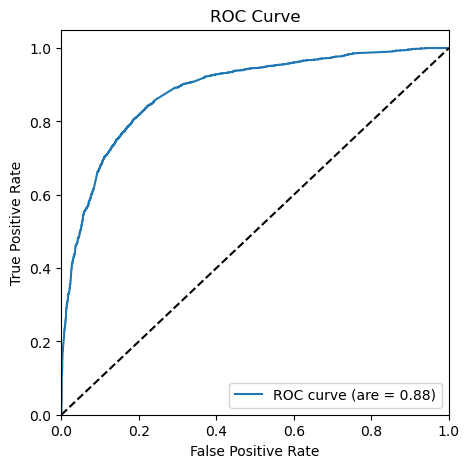

In [83]:
draw_roc(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

### Model has a AUC (area under curve) of 0.88 which is very good number and curve is closely hugging Y-axis

In [84]:
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID
0,0,0.254926,1871
1,0,0.247691,6795
2,0,0.299045,3516
3,0,0.817694,8105
4,0,0.194590,3934


## Choosing a optimal probability cutoff point using accuracy sensitivity and specificity curve

In [85]:
# create a column with different probability cutoffs

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > i else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.254926,1871,1,1,1,0,0,0,0,0,0,0
1,0,0.247691,6795,1,1,1,0,0,0,0,0,0,0
2,0,0.299045,3516,1,1,1,0,0,0,0,0,0,0
3,0,0.817694,8105,1,1,1,1,1,1,1,1,1,0
4,0,0.194590,3934,1,1,0,0,0,0,0,0,0,0


### True Positive[TP]    = confusion_matrix[1,1]
### True Negative[TN]   = confusion_matrix[0,0]
### False Positive[FP]   = confusion_matrix[0,1]
### False Negative[FN] = confusion_matrix[1,0]

In [86]:
# calculate accuracy sensitivity and specificity for various probability cutoff
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

num = [float(x)/10 for x in range(10)]

for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final[i])
    total1 = sum(sum(cm1))

    # (TP + TN) / (TP + TN + FP + FN)
    accuracy = (cm1[0,0] + cm1[1,1])/ total1
    # TP / (TP + FN)
    sensitivity = cm1[1,1] / (cm1[1,0] + cm1[1,1])
    # TN / (TN + FP)
    specificity = cm1[0,0] / (cm1[0,0] + cm1[0,1])

    cutoff_df.loc[i] = [i, accuracy, sensitivity, specificity]

cutoff_df

,prob,accuracy,sensitivity,specificity
0.0,0.0,0.381262,1.000000,0.000000
0.1,0.1,0.589672,0.967559,0.356822
0.2,0.2,0.758349,0.906326,0.667166
0.3,0.3,0.802412,0.839011,0.779860
0.4,0.4,0.814780,0.770073,0.842329
0.5,0.5,0.817873,0.704380,0.887806
0.6,0.6,0.798083,0.592457,0.924788
0.7,0.7,0.783241,0.515004,0.948526
0.8,0.8,0.759122,0.414842,0.971264
0.9,0.9,0.716296,0.275345,0.988006


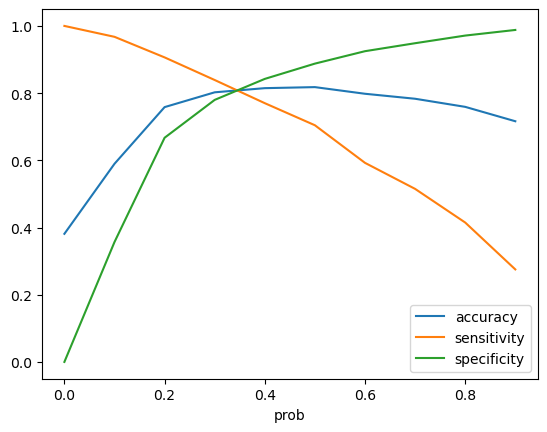

In [87]:
# plot accuracy sensitivity and specificity curve
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

### 0.35 probability cutoff can be chosen as optimal point from above plot

In [88]:
# predicting the target variable based on probability value chose from the plot
y_train_pred_final['final_predicted'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.35 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.254926,1871,1,1,1,0,0,0,0,0,0,0,0
1,0,0.247691,6795,1,1,1,0,0,0,0,0,0,0,0
2,0,0.299045,3516,1,1,1,0,0,0,0,0,0,0,0
3,0,0.817694,8105,1,1,1,1,1,1,1,1,1,0,1
4,0,0.194590,3934,1,1,0,0,0,0,0,0,0,0,0


In [89]:
# checking accuracy
metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.final_predicted)

0.8102968460111317

In [90]:
# create confusion matrix
cm2 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted)
cm2

array([[3251,  751],
       [ 476, 1990]])

In [91]:
# calculate sensitivity or recall
cm2[1,1] / (cm2[1,1] + cm2[1,0])

0.8069748580697486

In [92]:
# calculate specificity
cm2[0,0] / (cm2[0,1] + cm2[0,0])

0.8123438280859571

In [93]:
# False positive rate
1 - (cm2[0,0] / (cm2[0,1] + cm2[0,0]))

0.18765617191404294

In [94]:
# calculate precision
cm2[1,1] / (cm2[1,1] + cm2[0,1])

0.7260124042320321

In [95]:
# Negative predictive rate
cm2[0,0] / (cm2[0,0] + cm2[1,0])

0.8722833378052053

## Choosing a optimal probability cutoff point using precision recall curve

In [96]:
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
0,0,0.254926,1871,1,1,1,0,0,0,0,0,0,0,0
1,0,0.247691,6795,1,1,1,0,0,0,0,0,0,0,0
2,0,0.299045,3516,1,1,1,0,0,0,0,0,0,0,0
3,0,0.817694,8105,1,1,1,1,1,1,1,1,1,0,1
4,0,0.194590,3934,1,1,0,0,0,0,0,0,0,0,0


In [97]:
p,r,thresholds = precision_recall_curve(y_train_pred_final.Converted, y_train_pred_final.Conversion_Prob)

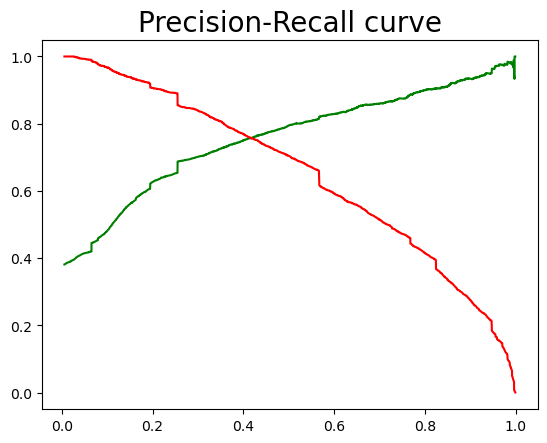

In [98]:
plt.plot(thresholds,p[:-1],'g-')
plt.plot(thresholds, r[:-1], 'r-')
plt.title(label="Precision-Recall curve",fontsize=20,color="black")
plt.show()

### 0.4 is the probability cutoff using precision recall curve which is close to the previous cutoff chosen

In [99]:
# predicting the target variable based on probability value chose from the plot
y_train_pred_final['final_predicted_PR'] = y_train_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.4 else 0)

y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,final_predicted_PR
0,0,0.254926,1871,1,1,1,0,0,0,0,0,0,0,0,0
1,0,0.247691,6795,1,1,1,0,0,0,0,0,0,0,0,0
2,0,0.299045,3516,1,1,1,0,0,0,0,0,0,0,0,0
3,0,0.817694,8105,1,1,1,1,1,1,1,1,1,0,1,1
4,0,0.194590,3934,1,1,0,0,0,0,0,0,0,0,0,0


In [100]:
# checking accuracy
metrics.accuracy_score(y_train_pred_final.Converted,y_train_pred_final.final_predicted_PR)

0.8147804576376005

In [101]:
# create confusion matrix
cm3 = metrics.confusion_matrix(y_train_pred_final.Converted, y_train_pred_final.final_predicted_PR)
cm3

array([[3371,  631],
       [ 567, 1899]])

In [102]:
# calculate sensitivity or recall
cm3[1,1] / (cm3[1,1] + cm3[1,0])

0.7700729927007299

In [103]:
# calculate specificity
cm3[0,0] / (cm3[0,1] + cm3[0,0])

0.842328835582209

In [104]:
# False positive rate
1 - (cm3[0,0] / (cm3[0,1] + cm3[0,0]))

0.15767116441779105

In [105]:
# calculate precision
cm3[1,1] / (cm3[1,1] + cm3[0,1])

0.7505928853754941

In [106]:
# Negative predictive rate
cm3[0,0] / (cm3[0,0] + cm3[1,0])

0.8560182833925851

### In our use case not missing out on a potential lead who is most likely to convert is vital, So we need to reduce False Negatives as much as possible. Model with better Recall value is well suited.
### But we can afford to predict customers who are not going to convert as potential lead. So we can tolerate False Positives
### So choosing a probability cutoff of 0.35 is a better choice as it has a recall value of 81%

## Making Predictions on test set

In [107]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [108]:
X_test = X_test[col]
X_test.head()

,Do Not Email,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Lead Origin_Lead Add Form,Lead Source_Olark Chat,Lead Source_Welingak Website,Last Activity_Converted to Lead,Last Activity_Email Bounced,Last Activity_Olark Chat Conversation,What is your current occupation_Working Professional,Last Notable Activity_Email Link Clicked,Last Notable Activity_Email Opened,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website
4269,0,0.031873,0.444982,0.145455,0,0,0,0,0,0,0,0,0,0,0,0
2376,0,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,0,0,0,0
7766,0,0.019920,0.025968,0.090909,0,0,0,0,0,0,1,0,0,0,0,0
9199,0,0.000000,0.000000,0.000000,0,1,0,0,0,1,0,0,0,1,0,0
4359,0,0.000000,0.000000,0.000000,1,0,0,0,0,0,0,0,1,0,0,0


In [109]:
# predicting on test set
X_test_sm = sm.add_constant(X_test)
y_test_pred = res.predict(X_test_sm)
y_test_pred[:10]

4269    0.723797
2376    0.947172
7766    0.876224
9199    0.065374
4359    0.824293
9186    0.557207
1631    0.431766
8963    0.168308
8007    0.049123
5324    0.359627
dtype: float64

In [110]:
# converting into dataframe
y_test_pred = pd.DataFrame(y_test_pred)
y_test_df = pd.DataFrame(y_test)
y_test_df['LeadID'] = y_test_df.index

# removing index for both dataframes
y_test_pred.reset_index(drop=True, inplace = True)
y_test_df.reset_index(drop=True, inplace = True)

# appending both the data frames
y_test_pred_final = pd.concat([y_test_df,y_test_pred], axis = 1)

In [111]:
y_test_pred_final.head()

,Converted,LeadID,0
0,1,4269,0.723797
1,1,2376,0.947172
2,1,7766,0.876224
3,0,9199,0.065374
4,1,4359,0.824293


In [112]:
# renaming the column
y_test_pred_final = y_test_pred_final.rename(columns = {0: 'Conversion_Prob'})

# re-arrange the columns
y_test_pred_final = y_test_pred_final.reindex(['LeadID','Converted','Conversion_Prob'],axis = 1)

y_test_pred_final.head()

,LeadID,Converted,Conversion_Prob
0,4269,1,0.723797
1,2376,1,0.947172
2,7766,1,0.876224
3,9199,0,0.065374
4,4359,1,0.824293


In [113]:
# making prediction with cutoff as 0.35
y_test_pred_final['final_predicted'] = y_test_pred_final.Conversion_Prob.map(lambda x: 1 if x > 0.35 else 0)

y_test_pred_final.head()

,LeadID,Converted,Conversion_Prob,final_predicted
0,4269,1,0.723797,1
1,2376,1,0.947172,1
2,7766,1,0.876224,1
3,9199,0,0.065374,0
4,4359,1,0.824293,1


## Draw ROC curve for test data set

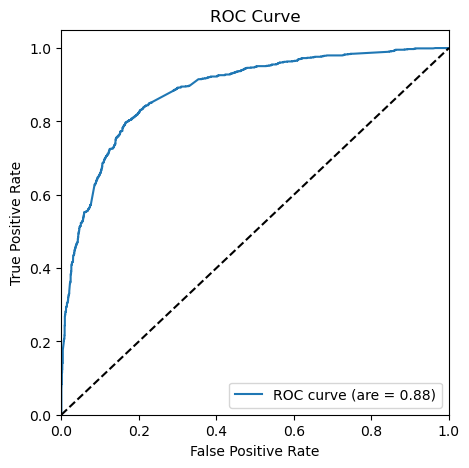

In [114]:
draw_roc(y_test_pred_final.Converted,y_test_pred_final.Conversion_Prob)

### AUC (area under curve) of test data set is 0.88 which is same as AUC obtained on train data

In [115]:
# checking accuracy
metrics.accuracy_score(y_test_pred_final.Converted,y_test_pred_final.final_predicted)

0.8152958152958153

In [116]:
# create confusion matrix
cm4 = metrics.confusion_matrix(y_test_pred_final.Converted, y_test_pred_final.final_predicted)
cm4

array([[1380,  297],
       [ 215,  880]])

In [117]:
# calculate sensitivity or recall
cm4[1,1] / (cm4[1,1] + cm4[1,0])

0.8036529680365296

In [118]:
# calculate specificity
cm4[0,0] / (cm4[0,1] + cm4[0,0])

0.8228980322003577

In [119]:
# False positive rate
1 - (cm4[0,0] / (cm4[0,1] + cm4[0,0]))

0.17710196779964227

In [120]:
# calculate precision
cm4[1,1] / (cm4[1,1] + cm4[0,1])

0.7476635514018691

In [121]:
# Negative predictive rate
cm4[0,0] / (cm4[0,0] + cm4[1,0])

0.8652037617554859

## Results obtained on test data is very similar to that obtained on test data

## Calculating lead score

In [122]:
# train data
y_train_pred_final['Lead_Score'] = round(y_train_pred_final['Conversion_Prob'] * 100)

In [123]:
y_train_pred_final.head()

,Converted,Conversion_Prob,LeadID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted,final_predicted_PR,Lead_Score
0,0,0.254926,1871,1,1,1,0,0,0,0,0,0,0,0,0,25.0
1,0,0.247691,6795,1,1,1,0,0,0,0,0,0,0,0,0,25.0
2,0,0.299045,3516,1,1,1,0,0,0,0,0,0,0,0,0,30.0
3,0,0.817694,8105,1,1,1,1,1,1,1,1,1,0,1,1,82.0
4,0,0.194590,3934,1,1,0,0,0,0,0,0,0,0,0,0,19.0


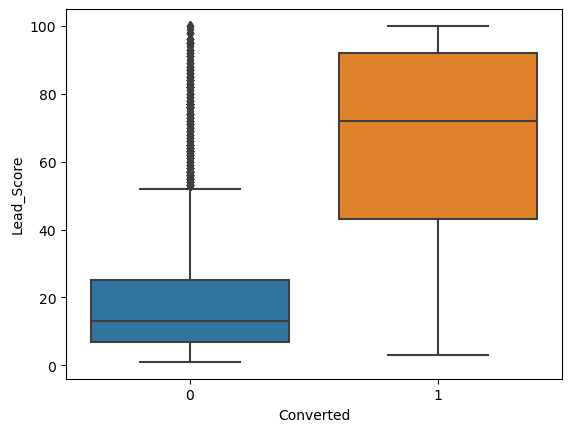

In [124]:
sns.boxplot(data = y_train_pred_final,x = 'Converted', y = 'Lead_Score')
plt.show()

In [125]:
y_train_pred_final[y_train_pred_final['Converted'] == 0]['Lead_Score'].describe()

count    4002.000000
mean       21.319340
std        20.785607
min         1.000000
25%         7.000000
50%        13.000000
75%        25.000000
max       100.000000
Name: Lead_Score, dtype: float64

In [126]:
y_train_pred_final[y_train_pred_final['Converted'] == 1]['Lead_Score'].describe()

count    2466.000000
mean       65.417275
std        28.522804
min         3.000000
25%        43.000000
50%        72.000000
75%        92.000000
max       100.000000
Name: Lead_Score, dtype: float64

### IQR range for converted leads lies between 43 and 92 which is higher than the non-converted leads
### IQR range for non-converted leads lies between 7 and 25

In [127]:
# test data
y_test_pred_final['Lead_Score'] = round(y_test_pred_final['Conversion_Prob'] * 100)

In [128]:
y_test_pred_final.head()

,LeadID,Converted,Conversion_Prob,final_predicted,Lead_Score
0,4269,1,0.723797,1,72.0
1,2376,1,0.947172,1,95.0
2,7766,1,0.876224,1,88.0
3,9199,0,0.065374,0,7.0
4,4359,1,0.824293,1,82.0


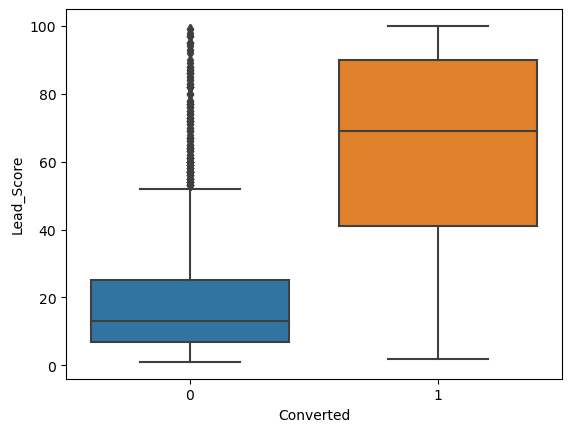

In [129]:
sns.boxplot(data = y_test_pred_final,x = 'Converted', y = 'Lead_Score')
plt.show()

### Test data set also shows similar behavior as train data set, higher IQR range for converted leads